In [54]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from kmodes.kmodes import KModes
from pprint import pprint

# supress warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
!ls | grep .csv

predict.csv
training.csv


In [3]:
train_df = pd.read_csv('training.csv')
train_orig_df = train_df.copy()
pred_df = pd.read_csv('predict.csv')
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,...,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,...,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,...,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,...,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


### Preprocessing

Firstly, we need to create a dataframe, consisting only of categorical data (as K-Modes only work with such info).

In [5]:
# Get rid of redundant columns
all_cols = [col for col in train_df.columns if col != 'rank']
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_employee', 'participant1_is_lead', 'participant1_order',
                  'participant2_is_employee', 'participant2_is_lead', 'participant2_order',
                  'participant3_is_employee', 'participant3_is_lead', 'participant3_order',
                  'participant4_is_employee', 'participant4_is_lead', 'participant4_order',
                  'participant5_is_employee', 'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age']
useful_cols = [i for i in all_cols if i not in redundant_cols]

train_df = train_df[useful_cols]

In [6]:
# Categorizing useful columns
all_cols = [col for col in train_df.columns if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))

Amount of number columns: 22
Amount of categorical columns: 19


In [7]:
print('Looking at the categorical columns:')
for cat_col in cat_cols:
    print('\tColumn {:19} has {} unique values.'.format(cat_col, train_df[cat_col].nunique()))

Looking at the categorical columns:
	Column app_type            has 6 unique values.
	Column owner_type          has 2 unique values.
	Column poster_gender       has 2 unique values.
	Column poster_focus        has 5 unique values.
	Column participant1_action has 3 unique values.
	Column participant1_gender has 2 unique values.
	Column participant1_focus  has 4 unique values.
	Column participant2_action has 3 unique values.
	Column participant2_gender has 2 unique values.
	Column participant2_focus  has 4 unique values.
	Column participant3_action has 3 unique values.
	Column participant3_gender has 2 unique values.
	Column participant3_focus  has 4 unique values.
	Column participant4_action has 3 unique values.
	Column participant4_gender has 2 unique values.
	Column participant4_focus  has 4 unique values.
	Column participant5_action has 3 unique values.
	Column participant5_gender has 2 unique values.
	Column participant5_focus  has 4 unique values.


Lets also look, which of the numerical columns we can turn into categorical ones.

In [8]:
print('Looking at the numerical columns:')
train_df[num_cols].describe().T

Looking at the numerical columns:


,count,mean,std,min,25%,50%,75%,max
owner_influence,9418.0,0.776456,0.367675,0.10000,0.74359,0.99923,0.99977,0.99992
number_of_likes,9418.0,4.385007,6.943666,0.00000,0.00000,2.00000,6.00000,64.00000
number_of_comments,9418.0,1.650032,3.725452,0.00000,0.00000,1.00000,2.00000,145.00000
reactivity,9418.0,0.317174,0.434830,0.00000,0.00000,0.00000,1.00000,1.00000
is_mentions_me,9418.0,0.003716,0.060851,0.00000,0.00000,0.00000,0.00000,1.00000
is_mentions_connections,9418.0,0.164260,0.370531,0.00000,0.00000,0.00000,0.00000,1.00000
is_commented_by_me,9418.0,0.016245,0.126425,0.00000,0.00000,0.00000,0.00000,1.00000
is_commented_by_connections,9418.0,0.493948,0.499990,0.00000,0.00000,0.00000,1.00000,1.00000
is_liked_by_me,9418.0,0.033659,0.180359,0.00000,0.00000,0.00000,0.00000,1.00000
is_liked_by_connections,9418.0,0.651625,0.476481,0.00000,0.00000,1.00000,1.00000,1.00000


In [9]:
# Creating categorical dataframe with bins from numerical data.

cat_train_df = train_df.copy()
for col in num_cols:
    if col == 'number_of_likes':
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 71, 10), include_lowest=True)
    elif col == 'number_of_comments':
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 151, 10), include_lowest=True)
    else:  # process all the columns, that are in [0, 1] range
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 1.1, 0.1), include_lowest=True)
    
    cat_train_df[col+'_bins'] = cut_df

cat_train_df.drop(num_cols, axis=1, inplace=True)
cat_train_df.head()

,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,...,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
0,other,space,male,marketing,liked,male,marketing,viewed,male,other,...,"(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
1,forum,space,male,marketing,commented,male,other,commented,male,marketing,...,"(-0.001, 0.1]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
2,forum,space,male,marketing,commented,male,other,commented,male,marketing,...,"(-0.001, 0.1]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
3,other,space,male,marketing,viewed,male,other,viewed,male,marketing,...,"(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
4,other,space,male,marketing,viewed,male,other,viewed,male,marketing,...,"(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"


### KModes Clustering

In [10]:
clusters = KModes(n_clusters=4, init='Cao', n_init=1, verbose=1).fit_predict(cat_train_df)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5937, cost: 63530.0
Run 1, iteration: 2/100, moves: 1663, cost: 62254.0
Run 1, iteration: 3/100, moves: 513, cost: 61883.0
Run 1, iteration: 4/100, moves: 234, cost: 61734.0
Run 1, iteration: 5/100, moves: 52, cost: 61734.0


In [11]:
clusters

array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

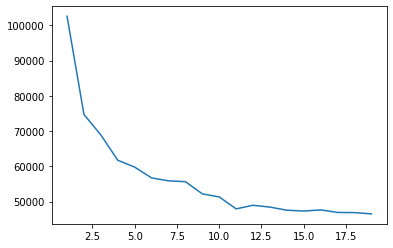

In [12]:
inertia = []
for num_clusters in range(1, 15):
    kmodes = KModes(n_clusters=num_clusters, init="Cao", n_init=1, verbose=0).fit(cat_train_df)
    inertia.append(kmodes.cost_)
    
# Plotting data.
plt.plot(np.arange(1, 15), inertia)

Lets take a K = 4 as a possible elbow point.

In [13]:
clusters = KModes(n_clusters=4, init='Cao', n_init=1, verbose=2).fit_predict(cat_train_df)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5937, cost: 63530.0
Run 1, iteration: 2/100, moves: 1663, cost: 62254.0
Run 1, iteration: 3/100, moves: 513, cost: 61883.0
Run 1, iteration: 4/100, moves: 234, cost: 61734.0
Run 1, iteration: 5/100, moves: 52, cost: 61734.0


In [14]:
clusters

array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

In [16]:
final_df = cat_train_df.copy()
final_df['cluster'] = clusters
final_df['rank'] = train_orig_df['rank']
final_df.head()

,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,...,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins,cluster,rank
0,other,space,male,marketing,liked,male,marketing,viewed,male,other,...,"(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]",0,0.73677
1,forum,space,male,marketing,commented,male,other,commented,male,marketing,...,"(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]",0,0.78240
2,forum,space,male,marketing,commented,male,other,commented,male,marketing,...,"(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]",0,0.82125
3,other,space,male,marketing,viewed,male,other,viewed,male,marketing,...,"(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]",3,0.61522
4,other,space,male,marketing,viewed,male,other,viewed,male,marketing,...,"(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]",3,0.61522


### Visualizing Results

In [48]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import animation
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [45]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components, random_state=1).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    colors = plt.get_cmap('tab10').colors
    colors = plt.get_cmap('Set3').colors
    N = 360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for label in tsne_3d_df[label_column].unique():
        label_df = tsne_3d_df[tsne_3d_df[label_column] == label]
        sc = ax.scatter(label_df['x'], label_df['y'], label_df['z'], c=colors[label],
               label=f"Cluster {label}", s=6, depthshade=True)
  
    ax.legend(loc='upper right')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('kmodes_results/{}.gif'.format(name), writer='imagemagick')
    plt.show()

Doing one-hot encoding, so we can interpret data well enough.

In [40]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

final_enc_df = train_df.copy()
final_enc_df = final_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
final_enc_df = final_enc_df.drop(cat_cols, axis=1)

final_enc_df['cluster'] = clusters
final_enc_df['rank'] = train_orig_df['rank']

In [41]:
tsne_3d_df = prepare_tsne(3, final_enc_df, clusters)

In [43]:
tsne_3d_df.head()

,x,y,z,labels
0,-0.605208,-10.248033,26.436798,0
1,24.933649,-4.774766,7.770442,0
2,-9.620039,6.191123,-9.901262,0
3,-12.144162,18.253176,-8.919492,3
4,-12.144162,18.253176,-8.919492,3


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

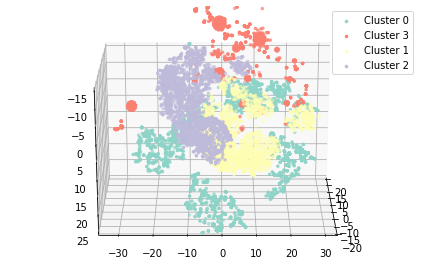

In [46]:
plot_animation(tsne_3d_df, 'labels', 'kmodes')

### Interpreting Results

In [49]:
from sklearn.preprocessing import MinMaxScaler

#### Using pandas.DataFrame.describe()

In [70]:
for i in range(np.max(final_df['cluster']) + 1):
    print("Cluster {}:".format(i))
    summary = final_df[final_df['cluster'] == i].drop(['cluster', 'rank'], axis=1).describe(include='all').T
    #display(summary)
    summary['% of top'] = summary.apply(lambda row: '{:.3f}'.format(row['freq'] * 100 / row['count']), axis=1)
    display(summary.T)

Cluster 0:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795,2795
unique,6,2,2,5,2,2,4,3,2,4,3,2,4,3,2,4,1,1,2,6,1,1,6,2,2,2,2,2,2,2,9,2,6,2,9,2,8,2,5,1,1
top,other,space,male,marketing,commented,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
freq,1896,2455,2329,2023,1619,2355,1885,1197,2484,1640,2149,2692,1692,2741,2784,1827,2795,2795,2203,2043,2795,2795,1496,2789,2632,2760,1516,2755,1701,2037,2672,2038,2736,2373,1547,2645,2152,2776,2741,2795,2795
% of top,67.835,87.835,83.327,72.379,57.925,84.258,67.442,42.826,88.873,58.676,76.887,96.315,60.537,98.068,99.606,65.367,100.000,100.000,78.819,73.095,100.000,100.000,53.524,99.785,94.168,98.748,54.240,98.569,60.859,72.880,95.599,72.916,97.889,84.902,55.349,94.633,76.995,99.320,98.068,100.000,100.000


Cluster 1:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511,2511
unique,6,2,2,4,2,2,4,2,2,4,2,2,4,2,2,4,2,2,4,6,5,1,6,2,2,2,2,2,2,2,6,2,6,2,7,2,8,2,6,2,8
top,other,space,male,marketing,liked,male,marketing,liked,male,marketing,liked,male,marketing,liked,male,marketing,liked,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]"
freq,2407,1558,1861,1849,1339,1970,1858,2041,1925,1874,2508,1917,1845,2275,1928,1661,1900,1943,1567,1644,1938,2511,1345,2508,2468,2491,1568,2390,2509,1894,2472,1899,2468,1898,2485,1873,2489,1902,2241,1992,1874
% of top,95.858,62.047,74.114,73.636,53.325,78.455,73.994,81.282,76.663,74.632,99.881,76.344,73.477,90.601,76.782,66.149,75.667,77.380,62.405,65.472,77.180,100.000,53.564,99.881,98.288,99.204,62.445,95.181,99.920,75.428,98.447,75.627,98.288,75.587,98.965,74.592,99.124,75.747,89.247,79.331,74.632


Cluster 2:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436,2436
unique,6,2,2,5,1,2,4,1,2,4,2,2,4,3,2,4,3,2,4,6,7,10,6,2,2,2,2,2,2,2,8,2,6,2,7,2,7,2,8,2,8
top,other,space,male,marketing,commented,male,marketing,commented,male,marketing,commented,male,marketing,commented,male,marketing,commented,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]","(-0.001, 0.1]","(0.9, 1.0]","(-0.001, 0.1]","(0.9, 1.0]","(-0.001, 0.1]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]"
freq,1739,2250,2028,1971,2436,2134,1573,2436,2111,1863,2293,2051,1835,1664,2059,1740,1040,2091,1593,2061,1859,2315,1135,2410,1341,2339,2395,2280,1926,1892,2335,1562,2413,1958,2377,1898,2365,1881,2261,2014,1880
% of top,71.388,92.365,83.251,80.911,100.000,87.603,64.573,100.000,86.658,76.478,94.130,84.195,75.328,68.309,84.524,71.429,42.693,85.837,65.394,84.606,76.314,95.033,46.593,98.933,55.049,96.018,98.317,93.596,79.064,77.668,95.854,64.122,99.056,80.378,97.578,77.915,97.085,77.217,92.816,82.677,77.176


Cluster 3:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676,1676
unique,6,2,2,4,3,2,3,3,2,3,3,2,4,2,2,2,1,1,2,6,1,1,6,1,1,2,2,1,2,2,9,2,3,2,4,2,5,2,2,1,1
top,other,space,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,viewed,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(-0.001, 0.1]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
freq,1027,1438,1489,1093,1632,1675,1674,1632,1667,1672,1637,1663,1670,1675,1675,1671,1676,1676,1670,1072,1676,1676,1645,1676,1676,1675,1641,1676,1675,1225,1482,1636,1633,1661,1632,1656,1638,1675,1675,1676,1676
% of top,61.277,85.800,88.842,65.215,97.375,99.940,99.881,97.375,99.463,99.761,97.673,99.224,99.642,99.940,99.940,99.702,100.000,100.000,99.642,63.962,100.000,100.000,98.150,100.000,100.000,99.940,97.912,100.000,99.940,73.091,88.425,97.613,97.434,99.105,97.375,98.807,97.733,99.940,99.940,100.000,100.000


#### K-Modes (k=4)

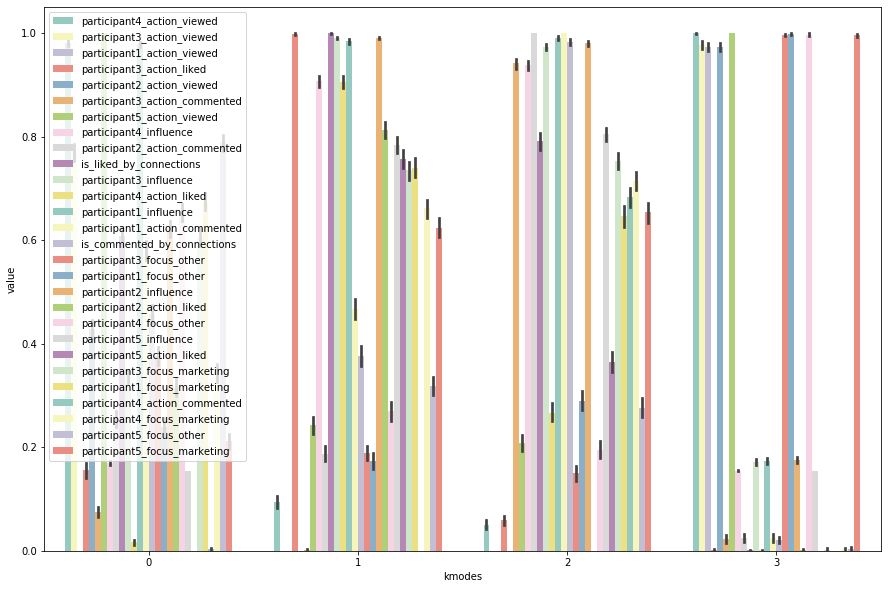

In [73]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['kmodes'] = clusters

df_mean = scaled_df.groupby('kmodes').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(28)['var'].values) + ['kmodes']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='kmodes')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='kmodes', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmodes_results/kmodes_results.jpg", dpi=300)